# Exercise 17: Regularized regression

This homework assignment is designed to give you an intuition as an interesting property of regularization in the context of ultra-high dimensional statistical problems.

You won't need to load in any data for this homework.

---
## 1. Simulating & visualizing data (2 points)

We are going to be looking at what happens in the context where $p>n$. In order to have total control over our data, we will use simulations for this homework. First, we will need to load the `glmnet`, `tidyverse`, and `ggplot2` libraries for this assignment.


In [3]:
install.packages("glmnet")
library(glmnet)
library(tidyverse)
library(ggplot2)



The downloaded binary packages are in
	/var/folders/zy/7fkr_dls50x53mn7v230d3k00000gp/T//RtmpWupupi/downloaded_packages


Loading required package: Matrix

Loaded glmnet 4.1-8

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::expand() masks Matrix::expand()
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x tidyr::pack()   masks Matrix::pack()
x tidyr::unpack() masks Matrix::unpack()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


We are going to generate a data set with complex structure and try to recover it using polynomial models. For simplicity sake, use the following code to produce a response variable, $y$ that has complex structure.

*Hint: Look up what a cosine function looks like if you need a reminder.*

In [4]:
# Generate data
set.seed(121)
sigma_noise = .5
x=seq(-9,9,by=.18)
n=length(x)
y = 0.1*x + cos(x) + cos(x/20)+rnorm(n,sd=sigma_noise)

(a) Break the data into a training set (n=50) and test set (n=51) using the `sample` function to randomly select subsets of x and y.  Make a separate data frame for the training and test data.

(**Note**: *Do not* just take the first 50 observations to be the training set and last 51 observations to be the test set.)

In [5]:
# check total number of observations
print(paste("Total number of observations: ", n))

# create a data frame
df = data.frame(x=x, y=y)

# set seed for reproducibility
set.seed(121)

# randomly select 50 incides for training set
train_indices <- sample(1:n, 50)

# x and y for training set
x_train <- df$x[train_indices]
y_train <- df$y[train_indices]

# x and y for test set
x_test <- df$x[-train_indices]
y_test <- df$y[-train_indices]

# create training and test sets
train_data <- df[train_indices, ]
test_data <- df[-train_indices, ]

# verify the dimensions of the training and test sets
print(paste("Training set dimensions: ", dim(train_data)))
print(paste("Test set dimensions: ", dim(test_data)))

# look at first few rows of the training set
head(train_data)
head(test_data)



[1] "Total number of observations:  101"
[1] "Training set dimensions:  50" "Training set dimensions:  2" 
[1] "Test set dimensions:  51" "Test set dimensions:  2" 


,x,y
,<dbl>,<dbl>
52,0.18,0.9768865
28,-4.14,-0.5463294
12,-7.02,0.5469083
71,3.60,0.9704096
4,-8.46,-0.5442746
73,3.96,0.7313249


,x,y
,<dbl>,<dbl>
2,-8.82,-0.74611573
3,-8.64,-0.59952472
5,-8.28,-0.68257115
7,-7.92,0.21327419
9,-7.56,-0.08663415
10,-7.38,1.10789561


(b) Plot the training data ($x$ \& $y$). Describe the relationship that you see in the training data.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


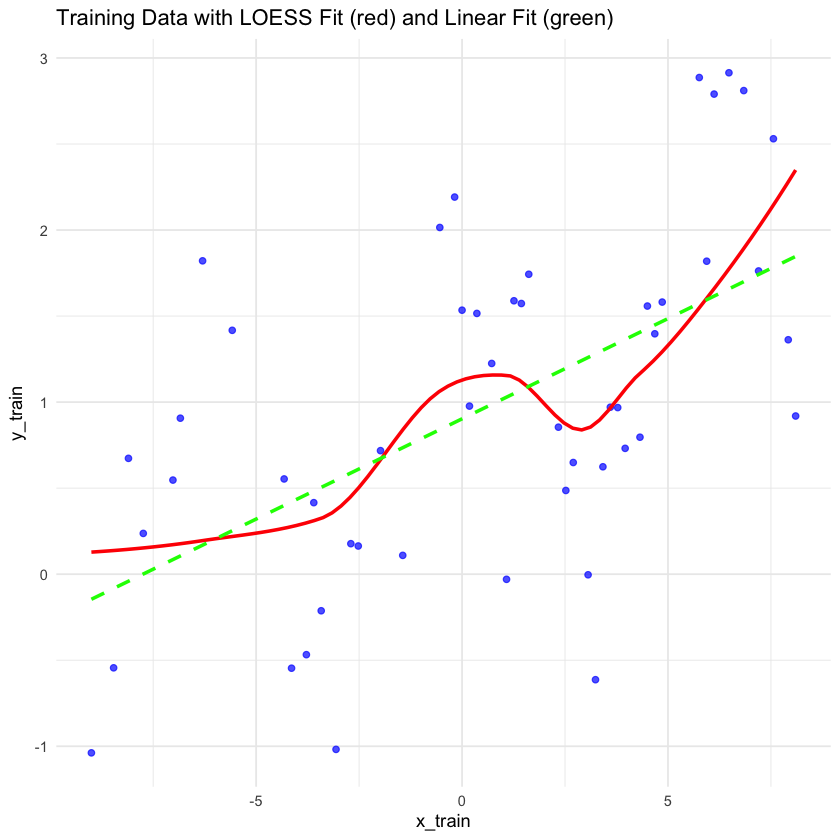

In [6]:
# plot the training data
ggplot(train_data, aes(x = x_train, y = y_train)) +
    geom_point(color = "blue", alpha = 0.7) +
    geom_smooth(method = "loess", se = FALSE, color = "red") +
    geom_smooth(method = "lm", se = FALSE, color = "green", linetype = "dashed") +
    labs(title = "Training Data with LOESS Fit (red) and Linear Fit (green)") +
    theme_minimal()


How would you describe the relationship between $x$ and $y$ based on this plot?

> *I put the LOESS in here for fun, it reveals a weighted and different take on the data. Regarding only the linear model, x increases as y increases, i.e. there is a positive correlation but, as the scattered plots show, it's not a high confidence fit.*
>

---
## 2. Bias-variance tradeoff: polynomial regression (4 points)

Recall that in polynomial regression we increase model complexity by expanding $x$ out to the power $k$ (which we call degree).


$$Y = \hat{\beta}_0 + \sum_{j=1}^K \hat{\beta}_jX^j $$  

$$ = poly(x,k)$$

(a) Fit a 2nd degree polynomial regression model to the training data. Plot the results.


*Hint: Use the* `help` *function to see how to use the* `stat_smooth()` *and* `poly()` *functions.*


Call:
lm(formula = y_train ~ poly(x_train, 2))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.83059 -0.61617  0.02948  0.64707  1.58144 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.9608     0.1176   8.170 1.42e-10 ***
poly(x_train, 2)1   3.9599     0.8315   4.762 1.87e-05 ***
poly(x_train, 2)2   0.8779     0.8315   1.056    0.296    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8315 on 47 degrees of freedom
Multiple R-squared:  0.3361,	Adjusted R-squared:  0.3078 
F-statistic:  11.9 on 2 and 47 DF,  p-value: 6.601e-05


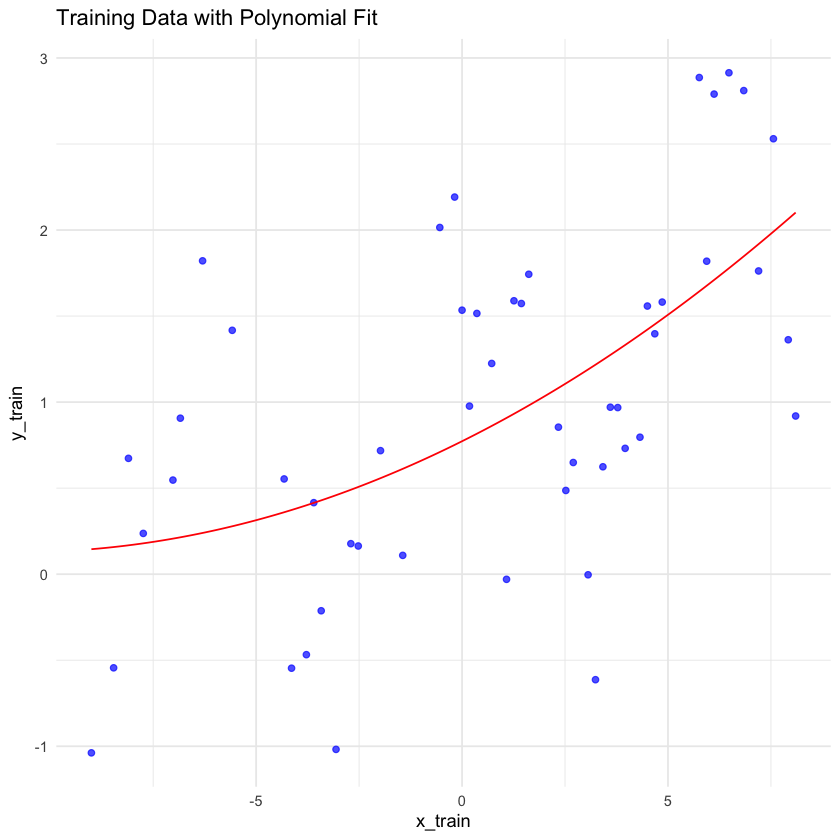

In [7]:
# fit a 2nd degree polynomial model
poly_model <- lm(y_train ~ poly(x_train, 2))

# create a data frame for predictions
x_range <- seq(min(x_train), max(x_train), length.out = 100)
predictions <- data.frame(x_train = x_range)
predictions$y_pred <- predict(poly_model, newdata = predictions)

# plot the training data and the polynomial fit
ggplot(train_data, aes(x = x_train, y = y_train)) +
    geom_point(color = "blue", alpha = 0.7) +
    geom_line(data = predictions, aes(x = x_train, y = y_pred), color = "red") +
    labs(title = "Training Data with Polynomial Fit") +
    theme_minimal()

# summary of the polynomial model
summary(poly_model)



How well does this 2nd degree polynomial model qualitatively fit the data? Could it do better?

> *The intercept and first order component are both significant but the second component is not significant. THe Multiple R-squared shows the model represents about 33% of the variance (Adjusted R-squared ~30%), which isn't a thorough analysis. It could do better.*
>

(b) Fit a 12th degree polynomial to the data. Does this do qualitatively better or worse than the 2nd degree model?


Call:
lm(formula = y_train ~ poly(x_train, 12))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.34178 -0.27127  0.06749  0.34723  0.75104 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.9608     0.0756  12.709 4.57e-15 ***
poly(x_train, 12)1    3.9599     0.5345   7.408 8.17e-09 ***
poly(x_train, 12)2    0.8779     0.5345   1.642  0.10899    
poly(x_train, 12)3    0.4594     0.5345   0.859  0.39566    
poly(x_train, 12)4   -1.1742     0.5345  -2.197  0.03440 *  
poly(x_train, 12)5    0.1795     0.5345   0.336  0.73891    
poly(x_train, 12)6   -3.6957     0.5345  -6.914 3.70e-08 ***
poly(x_train, 12)7   -1.3201     0.5345  -2.470  0.01827 *  
poly(x_train, 12)8    1.9039     0.5345   3.562  0.00103 ** 
poly(x_train, 12)9    0.5383     0.5345   1.007  0.32044    
poly(x_train, 12)10  -0.9468     0.5345  -1.771  0.08475 .  
poly(x_train, 12)11   0.1844     0.5345   0.345  0.73207    
poly(x_train, 12)12  -0.2417     0.5345

2nd degree polynomial model R-squared:  0.3360892 
12th degree polynomial model R-squared:  0.7840141 


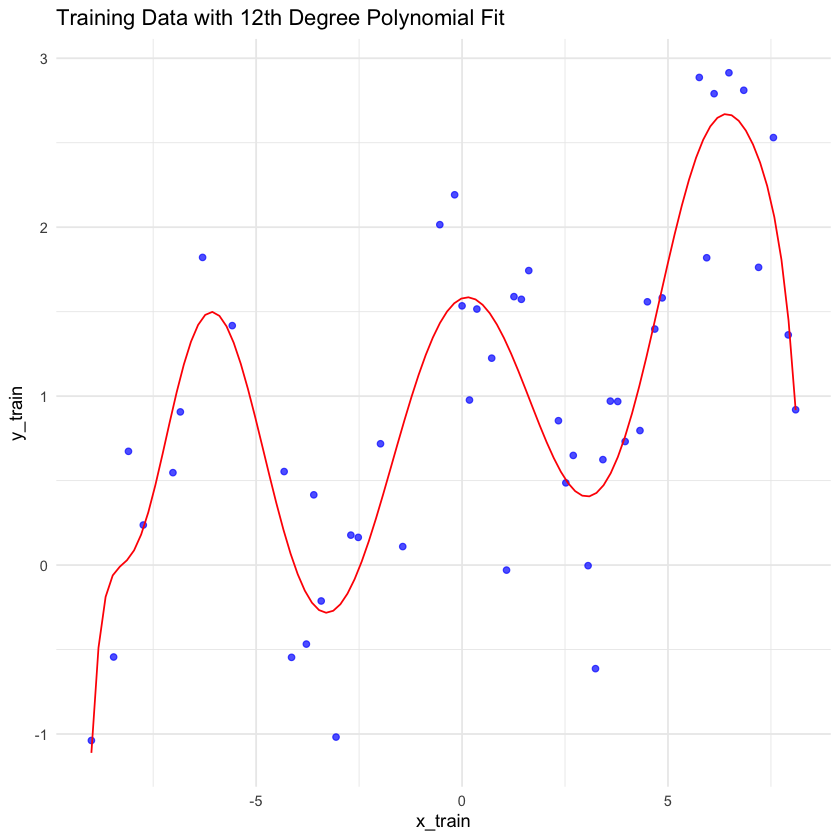

In [9]:
# fit a 12th degree polynomial model
poly_model_12 <- lm(y_train ~ poly(x_train, 12))

# create a data frame for predictions
predictions_12 <- data.frame(x_train = x_range)
predictions_12$y_pred <- predict(poly_model_12, newdata = predictions_12)

# plot the training data and the 12th degree polynomial fit
ggplot(train_data, aes(x = x_train, y = y_train)) +
    geom_point(color = "blue", alpha = 0.7) +
    geom_line(data = predictions_12, aes(x = x_train, y = y_pred), color = "red") +
    labs(title = "Training Data with 12th Degree Polynomial Fit") +
    theme_minimal()

# summary of the 12th degree polynomial model
summary(poly_model_12)

# compare R-squared values
cat("2nd degree polynomial model R-squared: ", summary(poly_model)$r.squared, "\n")
cat("12th degree polynomial model R-squared: ", summary(poly_model_12)$r.squared, "\n")



> *The 12th degree polynomial model has an R-squared of over 78%. It's a much more robust analysis and fit of the data.*
>

(c) Modify the loop below to estimate the bias-variance tradeoff as model complexity (i.e., degree of the polynomial model, $k$) increases from 2 to 50. Use the training data to fit the model and test data to evaluate its predictive accuracy.

Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree.


(**Note**: We are using median accuracies here because there are often 1 or 2 outlier values in the higher degree polynomial models that can throw off the accuracy estimates).

,degree,train_mse,test_mse
,<int>,<dbl>,<dbl>
1,2,0.3864916,0.5815313
2,3,0.3442140,0.5500326
3,4,0.3543288,0.3787839
4,5,0.3453804,0.4074797
5,6,0.1206089,0.3067919
6,7,0.1424988,0.3365191


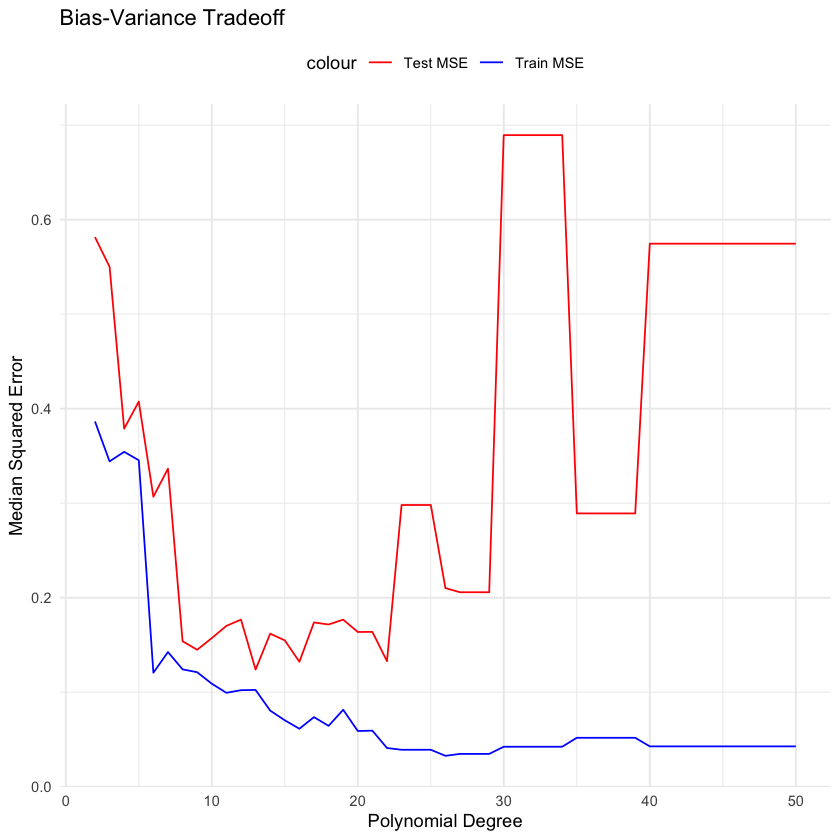

In [22]:
# Now do the variance-bias trade off analysis using regular regression
degree <- seq(2,50)

# Need to setup your output vectors
train_mse <- matrix(data=NA,nrow=length(degree),ncol=1)
test_mse <- matrix(data=NA,nrow=length(degree),ncol=1)

# Suppress warnings for cleaner output
options(warn = -1)

for (i in 1:length(degree)) {
    k <- degree[i]
    # fit a polynomial model of degree k
    poly_model_k <- lm(y ~ poly(x, k, raw = TRUE), data = train_data)
    
    # predictions for training set
    train_pred <- predict(poly_model_k, newdata = train_data)
    
    # predictions for test set
    test_pred <- predict(poly_model_k, newdata = test_data)
    
    # store median squared error for this degree
    train_mse[i] <- median((train_data$y - train_pred)^2)
    test_mse[i] <- median((test_data$y - test_pred)^2)
}

# Reset warning option
options(warn = 0)

results <- data.frame(degree, train_mse, test_mse)
head(results)

# Visualize the bias-variance tradeoff
ggplot( results, aes(x = degree)) +
    geom_line(aes(y = train_mse, color = "Train MSE")) +
    geom_line(aes(y = test_mse, color = "Test MSE")) +
    labs(title = "Bias-Variance Tradeoff", x = "Polynomial Degree", y = "Median Squared Error") +
    scale_color_manual(values = c("Train MSE" = "blue", "Test MSE" = "red")) +
    theme_minimal() +
    theme(legend.position = "top")

What do you see as $k$ increase?

> *As k increases the test_MSE generally goes down from 0 to ~22 but beyond that point the variance in the test set jumps wildly, increasing and decreasing, though always still above the lowest point when k < 22. In the train_MSE, however, as k increases, the MSE steadily decreases though with a few hiccups.*

> *I was confused with the code starting "train_rss" and "test_rss" since the instructions are clear that we're plotting median squared error. I changed the name of my variables accordingly.*

(d) Now copy the code above and let's see what happens when we go beyond $p=n$ (remember, in this case $k=p$). Test polynomial models up to $k=150$. Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree.

Use the `geom_vline()` function in `ggplot` to draw a vertical line where $k=n$ (here $n$ is the number of observations in the training set). This will make it clear where we cross the threshold for finding *unique* solutions in our data.



,degree,train_mse,test_mse
,<int>,<dbl>,<dbl>
1,2,0.3864916,0.5815313
2,3,0.3442140,0.5500326
3,4,0.3543288,0.3787839
4,5,0.3453804,0.4074797
5,6,0.1206089,0.3067919
6,7,0.1424988,0.3365191


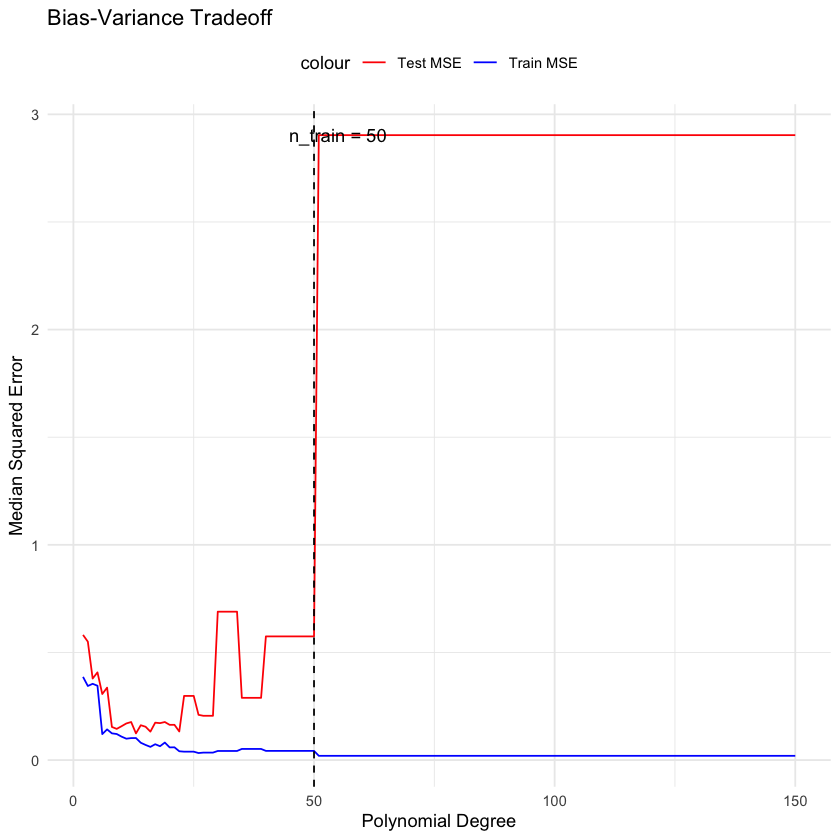

In [ ]:
# Now do the variance-bias trade off analysis using regular regression
degree <- seq(2,150)

# Need to setup your output vectors
train_mse <- matrix(data=NA,nrow=length(degree),ncol=1)
test_mse <- matrix(data=NA,nrow=length(degree),ncol=1)

# Suppress warnings for cleaner output
options(warn = -1)

for (i in 1:length(degree)) {
    k <- degree[i]
    # fit a polynomial model of degree k
    poly_model_k <- lm(y ~ poly(x, k, raw = TRUE), data = train_data)
    
    # predictions for training set
    train_pred <- predict(poly_model_k, newdata = train_data)
    
    # predictions for test set
    test_pred <- predict(poly_model_k, newdata = test_data)
    
    # store median squared error for this degree
    train_mse[i] <- median((train_data$y - train_pred)^2)
    test_mse[i] <- median((test_data$y - test_pred)^2)
}

# Reset warning option
options(warn = 0)

results <- data.frame(degree, train_mse, test_mse)
# Get number of training observations
n_train <- nrow(train_data)
head(results)

# Visualize the bias-variance tradeoff
ggplot(results, aes(x = degree)) +
    geom_line(aes(y = train_mse, color = "Train MSE")) +
    geom_line(aes(y = test_mse, color = "Test MSE")) +
    geom_vline(xintercept = n_train, linetype = "dashed", color = "black") +
    annotate("text", x = n_train + 5, y = max(c(train_mse, test_mse), 
        na.rm = TRUE), 
        label = paste("n_train =", n_train), color = "black") +
    labs(
        title = "Bias-Variance Tradeoff", 
        x = "Polynomial Degree", 
        y = "Median Squared Error") +
    scale_color_manual(values = c(
        "Train MSE" = "blue", 
        "Test MSE" = "red")) +
    theme_minimal() +
    theme(legend.position = "top")



What do you see as $k$ gets larger than $n$?

> *When k is larger than n the test_MSE goes up significantly and the train_ing _MSE levels off and is very low. This seems like an natural extension of what we saw in the previous question.*
>

---
## 3. Applying regularization to the model fits (2 points)

Repeat the previous bias-variance tradeoff test, going up to $k=150$, but now use ridge regression with a sparsity parameter of $\lambda=0.00005$. Plot your results the same way as last time.

,degree,train_mse,test_mse
,<int>,<dbl>,<dbl>
1,2,0.3864800,0.5326588
2,3,0.3443208,0.5096527
3,4,0.3541737,0.5124686
4,5,0.3453748,0.5455175
5,6,0.1306070,0.5624561
6,7,0.1269675,0.4052698


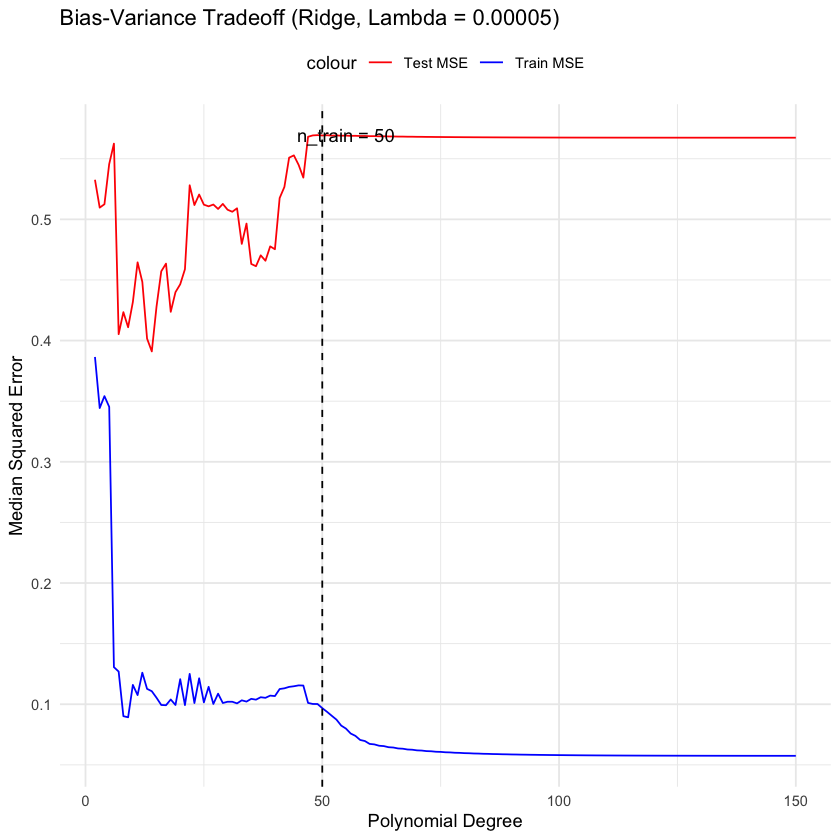

In [30]:
library(glmnet)
lambda <- 0.00005
degree <- seq(2,150)
rm(train_mse, test_mse)

# Need to setup your output vectors
train_mse <- matrix(data=NA,nrow=length(degree),ncol=1)
test_mse <- matrix(data=NA,nrow=length(degree),ncol=1)

# x and y for training set
x_train <- df$x[train_indices]
y_train <- df$y[train_indices]

# x and y for test set
x_test <- df$x[-train_indices]
y_test <- df$y[-train_indices]

# Suppress warnings for cleaner output
options(warn = -1)

for (i in 1:length(degree)) {
    k <- degree[i]
    
    # create polynomial features
    x_train_poly <- poly(x_train, k, raw = TRUE)
    x_test_poly <- poly(x_test, k, raw = TRUE)

    # fit a ridge regression model
    ridge_model_k <- glmnet(x_train_poly, y_train, alpha = 0, lambda = lambda, intercept = TRUE, standardize = TRUE) # Ridge regression
    
    # predictions for training set
    train_pred <- predict(ridge_model_k, lambda = lambda, newx = x_train_poly)
    
    # predictions for test set
    test_pred <- predict(ridge_model_k, lambda = lambda, newx = x_test_poly)
    
    # store median squared error for this degree
    train_mse[k - 1] <- median((y_train - train_pred)^2)
    test_mse[k - 1] <- median((y_train - test_pred)^2)
}

# Reset warning option
options(warn = 0)

results <- data.frame(degree, train_mse, test_mse)
# Get number of training observations
n_train <- nrow(train_data)
head(results)

# Visualize the bias-variance tradeoff
ggplot(results, aes(x = degree)) +
    geom_line(aes(y = train_mse, color = "Train MSE")) +
    geom_line(aes(y = test_mse, color = "Test MSE")) +
    geom_vline(xintercept = n_train, linetype = "dashed", color = "black") +
    annotate("text", x = n_train + 5, y = max(c(train_mse, test_mse), na.rm = TRUE), 
        label = paste("n_train =", n_train), color = "black") +
    labs(
        title = "Bias-Variance Tradeoff (Ridge, Lambda = 0.00005)", 
        x = "Polynomial Degree", 
        y = "Median Squared Error") +
    scale_color_manual(
        values = c("Train MSE" = "blue", 
                "Test MSE" = "red")) +
    theme_minimal() +
    theme(legend.position = "top")



What happens now when $k$ gets larger than $n$?

> *At first glance it's roughly the same as the last analysis, but the lambda value changes the model considerably and, while the model still levels off for the test_MSE, it does so at ~ 0.55 vs leveling off at almost 3.0 last time.*
>

---
## 4. Reflection (2 points)

The simulations above should have shown that, when applying a regularization (i.e., a sparsity constraint), the behavior of the bias-variance tradeoff changes. Explain why this happens.

> *With the last model as an example, the ridge regression and lambda manages model fit based on its value, large or small. The smaller the value of lambda, the more generous the model. As lambda decreases the flexibility of the fit increases. This increases the variance of the model and decreases the bias. So, with the very small lambda, we see a high level of fit, and that's a trade off that may or may not be useful or instructive, depending on the data set.*
>

---
## Bonus (1 extra credit point)
Recall that the $p=n$ threshold defines the limit for finding a *unique* solution to $Y=F(X)$ (i.e., there is only one combination of regression coefficients that is *best* at explaining variance in $Y$). With this in mind, what is regularization doing that works around this upper limit?

> *Write your response here*
>

**DUE:** 5pm EST, April 10, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *I worked with my coding tutor, claude.ai*